This notebook provides a summary of our approach to the project, with any issues we face and limitations/assumptions made.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import math

data_directory = "../data/curated/"
merchants = pd.read_parquet(data_directory + "merchants.parquet")
transactions = pd.read_parquet(data_directory + "transactions.parquet")
consumers = pd.read_parquet(data_directory + "consumers.parquet")
census = pd.read_csv(data_directory + "census.csv")

# Normalisation

Firstly, we noticed an issue with the merchant dataset: the 'tags' column was incorrectly constructed with an overload of information - it required normalisation, not only because it showcases technical competency, but the separation could be useful in ranking later on (for example, take-rate, revenue band and category of purchase may all be relevant when ranking and, ideally, should be in different columns).

Hence, a normalisation procedure was conducted on this column and the corresponding ETL implementation was done, too. 

In [21]:
merchants.head(5)

,name,tags,sector_tags,revenue_band,take_rate
merchant_abn,,,,,
10023283211,Felis Limited,"((furniture, home furnishings and equipment sh...","furniture, home furnishings and equipment shop...",e,0.18
10142254217,Arcu Ac Orci Corporation,"([cable, satellite, and otHer pay television a...","cable, satellite, and other pay television and...",b,4.22
10165489824,Nunc Sed Company,"([jewelry, watch, clock, and silverware shops]...","jewelry, watch, clock, and silverware shops",b,4.40
10187291046,Ultricies Dignissim Lacus Foundation,"([wAtch, clock, and jewelry repair shops], [b]...","watch, clock, and jewelry repair shops",b,3.29
10192359162,Enim Condimentum PC,"([music shops - musical instruments, pianos, a...","music shops - musical instruments, pianos, and...",a,6.33


# Preprocessing/Outlier Analysis

After downloading/extracting the relevant datasets that were provided to us and conducting some preliminary analysis, the first step was to examine outliers and determine a method to eliminate them from the dataset. 

In [12]:
transactions[transactions.isnull().any(axis=1)].head(10)

,user_id,merchant_abn,dollar_value,order_id,order_datetime,name,tags
index,,,,,,,
6,3,29566626791,46.330872,26b7574e-81c2-4558-a7d1-017ea9d29440,2021-02-28,None,None
39,18512,75342681786,11.114536,bdd7bdb2-f5c6-47e6-81f8-4e8c0d9882d2,2021-02-28,None,None
51,18519,27130058170,914.106232,f0a2ad39-0b6f-4b22-a87f-0345ae4bb677,2021-02-28,None,None
54,29,29323795999,9.257938,e74e8f04-2fe3-44d4-b081-0ccf1e8aba69,2021-02-28,None,None
68,32,32234779638,15.485283,ed81cbe9-2474-45a8-895a-9189c3877e84,2021-02-28,None,None
75,18535,33604812025,437.409129,1eadbf02-68a3-4f69-9e74-c4fb05e48df6,2021-02-28,None,None
77,18535,32234779638,166.279269,0ae141b2-2413-408a-8824-8c2bdd506da7,2021-02-28,None,None
108,66,17135205181,55.309494,be717197-58cf-4358-84e6-a4adcb3ba892,2021-02-28,None,None
110,67,29323795999,82.363296,10a03669-aca1-4858-ae56-e0c1a7d2a4e7,2021-02-28,None,None


We found that the nulls are predominantly related to the name of the merchant and what they purchased ('tags'). At the preliminary stage, it was determined that these can be considered vital features when ranking merchants, and if we lack this data, we hinder the accuracy of our selection metrics. Hence, all nulls were removed from further analysis.

To conduct further outlier analysis, we utilised a box plot (per merchant) to visualise the anomalies:

<AxesSubplot:xlabel='name', ylabel='dollar_value'>

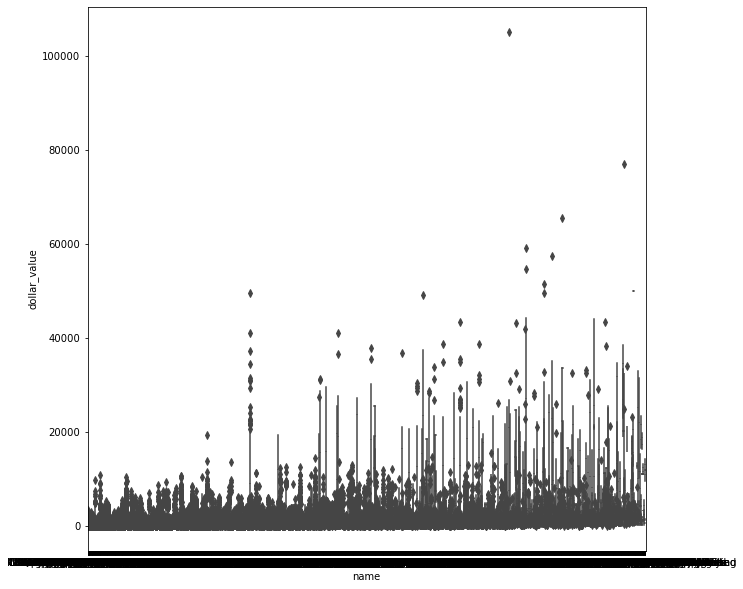

In [18]:
transactions_noNull = transactions.dropna()
plt.figure(figsize=(10,10))
sns.boxplot(x='name', y='dollar_value', data = transactions_noNull)

To eliminate the observed outliers, an IQR statistical implementation was used, resulting in approximately 3% of all data (113982 rows) being removed.

Complementing all these steps, a generic ETL script was being updated using separate functions for obtaining and preprocessing the data.

### Using a Fraud Model to Further Remove Data

After the release of the fraud dataset, we wanted to implement a model that detects fraudulent transactions and also removes them from the dataset.



### External Dataset

The external dataset (census data) was retrieved from the ABS website. We believed that some of these features could prove useful in deriving a ranking model. Additionally, as the census data linked customer data by postcode and gender, it is assumed that this average is representative of the individual.

Due to the hundreds of features available, feature engineering was done in order to obtain the most predictive attributes of a consumer. For example, a house-repayment-to-income ratio was deemed important as it showcases how risky - or how likely to default - a consumer is, and was engineered by dividing median mortgage payment of a consumer by their median income.

The data was then cleaned and merged into other datasets.

 ### Final (Merged) Dataset

By the preprocessing and outlier analysis detailed above for each dataset, we were able to obtain a final dataset by merging.

The ETL script was finalised, also. 

In [25]:
merged_transactions = pd.read_parquet(data_directory + "merged_transactions.parquet")

TypeError: unsupported operand type(s) for +: 'int' and 'dict'

# The Ranking Model and Segmentations

Initially, we devised a metric using three models: Customer-Merchant Model (CN), Customer Number Model (CNM) and Customer Sampling Model (CS). The CN model would be used to predict the amount each cutomer-merchant pair would spend on a monthly basis; the CNM model in conjunction with CS would be used to predict revenue for a specific month (using a Monte-Carlo sampling method). Ultimately, we would use all of this information to predict the future revenue for any given month for a specific merchant. However, we faced a number of issues in creation of this system:
- Customer were sparse: we found that each customer only had a few transactions per merchant, hence making it difficult to derive a predictive power
- Memory/Technical Issues: since these databases/operations were computationally heavy, we were met with several RAM issues across group members, as well as .env and environment errors which impeded the creation process significantly 

As a result, we decided to change the model to the one we have now. By using several, reputable articles and studies, we were able to select and create features 

- rankings.csv